## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [58]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from time import time
import os
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import itertools
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [59]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [120]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))

fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train = True, 
                                                        transform = train_transform,
                                                        target_transform = None,
                                                        download = download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train = False, 
                                                       transform = test_transform,
                                                       target_transform = None,
                                                       download = download)
def test_train_split(dataset, split = 0.8):    
    """
    Looks similar to sklearn one.
    Params:
    --------------
    dataset -- torch.utils.data.Dataset to split
    split -- float, split (to train size)
    Returns:
    --------------
    train_set, valid_set -- splitted Datasets of size:
    (split * len(dataset), len(dataset) - len(train_set))
    """
    train_size = int(split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset




In [121]:
len(fmnist_dataset_test)
train_loader = DataLoader(train_set, batch_size = 128,
                                           shuffle = True,
                                           num_workers = 2)


In [122]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [123]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape = 28 * 28, num_classes = 10, input_channels = 1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes))
        
    def forward(self, x):       
        return self.model(x)
    

In [124]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
           Dropout-4                  [-1, 256]               0
              ReLU-5                  [-1, 256]               0
       BatchNorm1d-6                  [-1, 256]             512
            Linear-7                   [-1, 10]           2,570
Total params: 204,554
Trainable params: 204,554
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.78
Estimated Total Size (MB): 0.80
----------------------------------------------------------------


Your experiments come here:

In [216]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

def train_model(model, train_set, valid_set, 
                loss_fn, opt, 
                n_epochs: int, 
                device = device,
                return_train_metrics = False):
    
    train_loader = DataLoader(train_set, batch_size = 128,
                                           shuffle = True,
                                           num_workers = 2)
    valid_loader = DataLoader(valid_set, batch_size = 256,
                                           shuffle = False,
                                           num_workers = 2)
    
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        ep_train_accuracy = []
        
        start_time = time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            predictions = model(X_batch)
            
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            
            with torch.no_grad():
                _ = model.eval()
                y_pred = predictions.max(1)[1] 
                ep_train_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu() \
                            .numpy().astype(float)) / len(y_batch.cpu()))
            
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                
                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1] 
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu() \
                            .numpy().astype(float))/ len(y_batch.cpu()))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        train_accuracy.append(np.mean(ep_train_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")
    return train_loss, train_accuracy, val_loss, val_accuracy 

def evaluate_model(model, test_set, loss_fn, opt):
    test_loader = DataLoader(test_set, batch_size = 128,
                                          shuffle = False,
                                          num_workers = 2)
    _ = model.eval()
    print("\n\n TESTING MODEL...")
    losses = []
    metrics = []
    model.train(False)
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            
            y_pred = predictions.max(1)[1]
            losses.append(loss.item())
            metrics.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu() \
                            .numpy().astype(float))/ len(y_batch.cpu()))
            
    print(f"\t test loss: {np.mean(losses):.6f}")
    print(f"\t test accuracy: {np.mean(metrics):.3f}")

    
    return np.mean(losses), np.mean(metrics)

Epoch 1 of 18 took 5.035s
	  training loss: 0.493545
	validation loss: 0.400922
	validation accuracy: 0.860
Epoch 2 of 18 took 4.680s
	  training loss: 0.381528
	validation loss: 0.366440
	validation accuracy: 0.869
Epoch 3 of 18 took 4.695s
	  training loss: 0.347846
	validation loss: 0.381247
	validation accuracy: 0.865
Epoch 4 of 18 took 4.528s
	  training loss: 0.323281
	validation loss: 0.361168
	validation accuracy: 0.866
Epoch 5 of 18 took 4.579s
	  training loss: 0.305446
	validation loss: 0.333266
	validation accuracy: 0.880
Epoch 6 of 18 took 4.437s
	  training loss: 0.292408
	validation loss: 0.317784
	validation accuracy: 0.884
Epoch 7 of 18 took 4.483s
	  training loss: 0.278010
	validation loss: 0.316421
	validation accuracy: 0.884
Epoch 8 of 18 took 4.540s
	  training loss: 0.269641
	validation loss: 0.324652
	validation accuracy: 0.882
Epoch 9 of 18 took 4.504s
	  training loss: 0.258069
	validation loss: 0.314517
	validation accuracy: 0.888
Epoch 10 of 18 took 4.517s
	

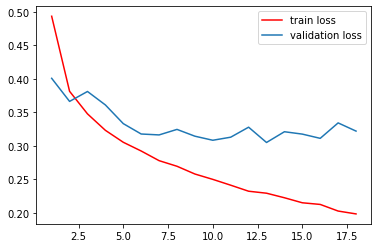

In [126]:
# Your experiments, training and validation loops here
n_epochs = 18
train_set, valid_set = test_train_split(fmnist_dataset_train)
train_loss, _, val_loss, val_accuracy = train_model(model, train_set, valid_set,
                                                loss_func, opt, n_epochs)
_ = evaluate_model(model, fmnist_dataset_test, loss_func, opt)
plt.plot(np.arange(1, n_epochs + 1, 1), train_loss, color = 'r', label = 'train loss')
plt.plot(np.arange(1, n_epochs + 1, 1), val_loss, label = 'validation loss')
plt.legend(loc = 'best')

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [256]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, n_layers = 1,
                 input_shape = 28 * 28, num_classes = 10, input_channels = 1):
        super(self.__class__, self).__init__()
        hidden_dim = 64
        self.model = torch.nn.Sequential(nn.Flatten())
        prev_layer_input_dim = input_shape
        for layer in range(n_layers):
            self.model.add_module('Layer {}'.format(layer + 1), 
                                  torch.nn.Linear(in_features = prev_layer_input_dim, 
                                                 out_features = hidden_dim))
            prev_layer_input_dim = hidden_dim
            
        self.model.add_module('classifier', 
                               torch.nn.Linear(prev_layer_input_dim, num_classes)) 
        
    def forward(self, x):       
        return self.model(x)

In [257]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
            Linear-3                   [-1, 10]             650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.19
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


In [258]:
train_set, _ = test_train_split(fmnist_dataset_train, .66)
loss_func = nn.CrossEntropyLoss()
layers_range = 10
def get_overfitting(layers_range):  
    test = {"loss": [], "error": []}
    train = {"loss": [], "error": []}
    
    for n_layers in range(layers_range):
        print("n_layers = ", n_layers)
        model = OverfittingNeuralNetwork(n_layers = n_layers).to(device)
        opt = torch.optim.Adam(model.parameters())
        train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, train_set, 
                                                    valid_set,
                                                    loss_func, opt, 10)

        test_loss, test_accuracy = evaluate_model(model, fmnist_dataset_test, loss_func, opt)
        train['error'].append(1. - np.mean(val_accuracy))
        test['error'].append(1. - test_accuracy)
    return train, test
train_data, test_data = get_overfitting(layers_range = layers_range)
# Your experiments, come here

n_layers =  0
Epoch 1 of 10 took 8.554s
	  training loss: 0.802925
	validation loss: 0.593558
	validation accuracy: 0.805
Epoch 2 of 10 took 8.086s
	  training loss: 0.550371
	validation loss: 0.508641
	validation accuracy: 0.830
Epoch 3 of 10 took 7.961s
	  training loss: 0.499750
	validation loss: 0.478439
	validation accuracy: 0.839
Epoch 4 of 10 took 7.536s
	  training loss: 0.473609
	validation loss: 0.460545
	validation accuracy: 0.844
Epoch 5 of 10 took 7.941s
	  training loss: 0.457144
	validation loss: 0.446608
	validation accuracy: 0.848
Epoch 6 of 10 took 7.364s
	  training loss: 0.444176
	validation loss: 0.439948
	validation accuracy: 0.848
Epoch 7 of 10 took 7.713s
	  training loss: 0.434500
	validation loss: 0.441192
	validation accuracy: 0.850
Epoch 8 of 10 took 8.304s
	  training loss: 0.428218
	validation loss: 0.429671
	validation accuracy: 0.854
Epoch 9 of 10 took 7.772s
	  training loss: 0.421886
	validation loss: 0.429180
	validation accuracy: 0.849
Epoch 10 of 10

Epoch 2 of 10 took 9.459s
	  training loss: 0.544749
	validation loss: 0.516765
	validation accuracy: 0.821
Epoch 3 of 10 took 9.080s
	  training loss: 0.513048
	validation loss: 0.502839
	validation accuracy: 0.826
Epoch 4 of 10 took 9.714s
	  training loss: 0.491833
	validation loss: 0.507034
	validation accuracy: 0.825
Epoch 5 of 10 took 9.548s
	  training loss: 0.475317
	validation loss: 0.484617
	validation accuracy: 0.830
Epoch 6 of 10 took 9.289s
	  training loss: 0.458448
	validation loss: 0.452185
	validation accuracy: 0.840
Epoch 7 of 10 took 10.076s
	  training loss: 0.446349
	validation loss: 0.442513
	validation accuracy: 0.848
Epoch 8 of 10 took 9.220s
	  training loss: 0.442158
	validation loss: 0.473669
	validation accuracy: 0.831
Epoch 9 of 10 took 9.703s
	  training loss: 0.440922
	validation loss: 0.434451
	validation accuracy: 0.846
Epoch 10 of 10 took 9.545s
	  training loss: 0.439392
	validation loss: 0.489691
	validation accuracy: 0.831


 TESTING MODEL...
	 test

(0.1, 0.23)

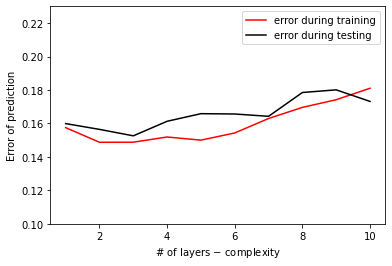

In [259]:
plt.ylabel("Error of prediction")
plt.plot(np.arange(1, layers_range + 1, 1),
         
         train_data['error'], color = 'r', label = "error during training")
plt.plot(np.arange(1, layers_range + 1, 1), 
         test_data['error'], color = 'k', label = "error during testing")
plt.xlabel("# of layers $-$ complexity"); plt.legend(loc = "best")
plt.ylim(.1, .23)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [252]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, n_layers = 1, input_shape = 28 * 28, num_classes = 10, 
                 input_channels = 1):
        super(self.__class__, self).__init__()
        hidden_dim = 64
        self.model = torch.nn.Sequential(nn.Flatten())
        prev_layer_input_dim = input_shape
        for layer in range(n_layers):
            self.model.add_module('Layer {}'.format(layer + 1), 
                                  torch.nn.Linear(in_features = prev_layer_input_dim, 
                                                 out_features = hidden_dim))
            self.model.add_module("Dropout {}".format(layer + 1), nn.Dropout(.25))
            
            self.model.add_module("BatchNorm {}".format(layer + 1), 
                                  torch.nn.BatchNorm1d(hidden_dim))
            prev_layer_input_dim = hidden_dim
        self.model.add_module("BatchNorm {}".format(n_layers), 
                                  torch.nn.BatchNorm1d(prev_layer_input_dim))
            
        self.model.add_module('classifier', nn.Linear(prev_layer_input_dim, num_classes))
                       
        
    def forward(self, x):       
        out = self.model(x)
        return out
                            

In [253]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
           Dropout-3                   [-1, 64]               0
       BatchNorm1d-4                   [-1, 64]             128
            Linear-5                   [-1, 10]             650
Total params: 51,018
Trainable params: 51,018
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.19
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [254]:
train_set, _ = test_train_split(fmnist_dataset_train, .8)
loss_func = nn.CrossEntropyLoss()
layers_range = 10

test_data = {"loss": [], "error": []}
train_data = {"loss": [], "error": []}
for n_layers in range(layers_range):
    print("n_layers = ", n_layers)
    model = FixedNeuralNetwork(n_layers = n_layers).to(device)
    opt = torch.optim.Adam(model.parameters())
    train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, train_set, 
                                                valid_set,
                                                loss_func, opt, 10)
    test_loss, test_accuracy = evaluate_model(model, fmnist_dataset_test, loss_func, opt)
    train_data['error'].append(1. - np.mean(val_accuracy))
    test_data['error'].append(1. - test_accuracy)
# Your experiments, come here

n_layers =  0
Epoch 1 of 10 took 12.919s
	  training loss: 0.728765
	validation loss: 0.516901
	validation accuracy: 0.820
Epoch 2 of 10 took 14.158s
	  training loss: 0.493681
	validation loss: 0.459692
	validation accuracy: 0.841
Epoch 3 of 10 took 12.724s
	  training loss: 0.454848
	validation loss: 0.436541
	validation accuracy: 0.850
Epoch 4 of 10 took 13.596s
	  training loss: 0.433273
	validation loss: 0.421311
	validation accuracy: 0.854
Epoch 5 of 10 took 13.563s
	  training loss: 0.421798
	validation loss: 0.409368
	validation accuracy: 0.857
Epoch 6 of 10 took 13.174s
	  training loss: 0.411996
	validation loss: 0.403807
	validation accuracy: 0.859
Epoch 7 of 10 took 13.294s
	  training loss: 0.404614
	validation loss: 0.399636
	validation accuracy: 0.860
Epoch 8 of 10 took 12.800s
	  training loss: 0.397245
	validation loss: 0.394980
	validation accuracy: 0.859
Epoch 9 of 10 took 13.509s
	  training loss: 0.392879
	validation loss: 0.389044
	validation accuracy: 0.865
Epoch

Epoch 1 of 10 took 20.329s
	  training loss: 0.797171
	validation loss: 0.570242
	validation accuracy: 0.795
Epoch 2 of 10 took 20.117s
	  training loss: 0.534433
	validation loss: 0.494686
	validation accuracy: 0.825
Epoch 3 of 10 took 19.404s
	  training loss: 0.497000
	validation loss: 0.459690
	validation accuracy: 0.839
Epoch 4 of 10 took 18.657s
	  training loss: 0.475299
	validation loss: 0.504263
	validation accuracy: 0.818
Epoch 5 of 10 took 20.169s
	  training loss: 0.467829
	validation loss: 0.478167
	validation accuracy: 0.833
Epoch 6 of 10 took 18.813s
	  training loss: 0.458510
	validation loss: 0.493580
	validation accuracy: 0.819
Epoch 7 of 10 took 19.162s
	  training loss: 0.454083
	validation loss: 0.479477
	validation accuracy: 0.828
Epoch 8 of 10 took 19.070s
	  training loss: 0.449749
	validation loss: 0.457503
	validation accuracy: 0.838
Epoch 9 of 10 took 19.194s
	  training loss: 0.439193
	validation loss: 0.429053
	validation accuracy: 0.848
Epoch 10 of 10 took

(0.1, 0.2)

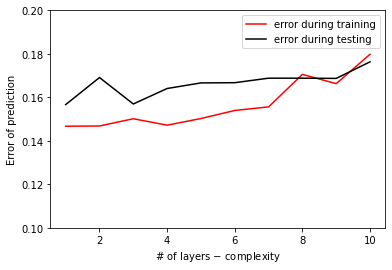

In [255]:
plt.ylabel("Error of prediction")
plt.plot(np.arange(1, layers_range + 1, 1),
         train_data['error'], color = 'r', label = "error during training")
plt.plot(np.arange(1, layers_range + 1, 1), 
         test_data['error'], color = 'k', label = "error during testing")
plt.xlabel("# of layers $-$ complexity"); plt.legend(loc = "best")
plt.ylim(.1, .2)

### Conclusions:
_Write down small report with your conclusions and your ideas._